In [73]:
import os
import PyPDF2
import fitz
import pandas as pd
import collections
import re

In [74]:
from nltk import tokenize
# import nltk
# nltk.download('punkt')

In [75]:
dir = 'annoted_sustainability_reports/Materials'

In [76]:
x_label = ["Linde", "Ecolab", "SherwinWilliams", "IntrntlFlavorsandFragrances", "FreeportMcmoran", "Nucor", 
     "AirProducts", "Corteva", "NewmontMining", "Dow"]

### Extracting Sentences: Refined Version

In [77]:
# this method will return a list of highlighted sentences in each page 
def get_page_highlights_coord(annot):
    page_highlights_coord = []
    while annot:
        if annot.type[0] == 8:
            all_coordinates = annot.vertices
            try:
                if len(all_coordinates) == 4:
                    highlight_coord = fitz.Quad(all_coordinates).rect
                    page_highlights_coord.append(highlight_coord)
                else:
                    all_coordinates = [all_coordinates[x:x+4] for x in range(0, len(all_coordinates), 4)]
                    for i in range(0,len(all_coordinates)):
                        coord = fitz.Quad(all_coordinates[i]).rect
                        page_highlights_coord.append(coord)
            except:
                print("NoneType found")
        annot = annot.next
    return page_highlights_coord
        

In [78]:
def get_page_highlights_text(page_highlights_coord, all_words, test_pos, repeat_coord):
    page_highlights = collections.defaultdict(list)
    for h in page_highlights_coord:
        test_dict = collections.defaultdict(list) # intialize a dictionary that keeps order and 
        # indication of where the sentence breaks occur
        for w in all_words:
            if (fitz.Rect(w[0:4]).intersects(h)): 
            # find intersections where the original report overlaps with the highlighted sentences
                new_pos = int(str("%02d" % w[5]) + str("%02d" % w[6]) + str("%02d" % w[7])) 
#                 print(new_pos, w[4])
                if new_pos not in repeat_coord:
                    repeat_coord.append(new_pos)
                    if test_pos <  new_pos:
#                         print('less than', test_pos, new_pos, w[4])
                        test_pos = new_pos 
                        test_dict[new_pos].append(w[4])
                        page_highlights[new_pos].append(test_dict[new_pos][0])
#                         page_highlights.append({new_pos : test_dict[new_pos]})
                    else:
#                         print('greater than', test_pos, new_pos, w[4])
                        test_dict = collections.defaultdict(list)
                        test_pos = 0
                        test_dict[new_pos].append(w[4])
                        page_highlights[new_pos].append(test_dict[new_pos][0])
#                         page_highlights.append({new_pos : test_dict[new_pos]})
                else:
                    continue
    return page_highlights
                    

In [79]:
def get_total_highlights_text(total_page_highlights):
    total_page_highlights_text = []
    for i in total_page_highlights:
        highlights = ""
        sorted_dict = sorted(i.items(), key = lambda kv:kv[0], reverse = False)
        for k in sorted_dict:
            highlights += k[1][0] + " "
            
        total_page_highlights_text.append(highlights)
    
    return total_page_highlights_text

In [80]:
# final list of relevant sentences
final_relevant = []   
final_relevant_comp = []

# final list of all sentences 
final_all = []
final_all_comp = []

# running all the files in the industry folder
for file in os.listdir(dir): 
    
    # f = filename + directory
    f = os.path.join(dir, file) 
    print(f)
    
    # comp_lab = to label sentence by companies
    comp_lab = list(filter(lambda x:  x in f, x_label))
    print(comp_lab)
    
    # opening each company report
    doc = fitz.open(f) 
    print(doc)
    
    # store the entire report in this list
    all_result = []
    
    test_pos = 0 # keep track of whether values of coordinates increase or decrease --> 
    #reinitialize if decreases because that means its a new set of sentences (paragraph)
    
    total_page_highlights = [] # use this list to store all the highlighted sentences of each page
    
#     test_final_relevant = [] # use this to test printing relevant sentences by company 

    # iterate each page of the document
    for page in doc:
        
        # extract all the sentences in pdf --> store it in all_result
        all_text = page.get_text_words()
        all_text = [i[4] for i in all_text]
        all_result.append(" ".join(all_text))
        print(" ".join(all_text))
        
        # extract highlighted sentences coordinates from pdf --> using the get_page_highlights_coord method
        annot = page.first_annot
        page_highlights_coord = get_page_highlights_coord(annot)
        
        # convert the page into text so that it can be compared with highlighted coordinates
        all_words = page.get_text_words()
#         print(all_words)
        
        # only iterate if highlights were detected
        if len(page_highlights_coord) > 0:
            repeat_coord = []
            # use the get_page_highlights_text to extract coordinates and words into dictionary 
            #(remove duplicated coordinates here as well)
            page_highlights = get_page_highlights_text(page_highlights_coord, all_words, test_pos, repeat_coord)
            total_page_highlights.append(page_highlights)
            
    # use get_total_highlights_text method to sort words by coordinates 
    # [so that we can get a cleaner version of sentences] and extract the final version of relevant sentences        
    total_highlights = get_total_highlights_text(total_page_highlights)
    
    # loop around total_highlights to tokenize sentences (breaking chunks into sentences)
    for i in total_highlights:
        i = re.sub("\xa0", " ", i)
        i = re.sub("\t", " ", i)
        i = re.sub("\r", " ", i)
        i = re.sub("\n", " ", i)
        i = re.sub(" +", " ", i)
#         i = i.strip()
        final_relevant += tokenize.sent_tokenize(i)
        final_relevant_comp += comp_lab * len(tokenize.sent_tokenize(i))
    
#     print('>>>>RELEVANT<<<<')
#     print(final_relevant)
#         test_final_relevant += tokenize.sent_tokenize(i.replace("\n", " "))

    # loop around all_result to tokenize sentences as well
    for i in all_result:
        i = re.sub("\xa0", " ", i)
        i = re.sub("\t", " ", i)
        i = re.sub("\r", " ", i)
        i = re.sub("\n", " ", i)
        i = re.sub(" +", " ", i)
#         i = i.strip()
        final_all += tokenize.sent_tokenize(i)
        final_all_comp += comp_lab * len(tokenize.sent_tokenize(i))
        
#     print('>>>>ALL<<<<')
#     print(final_all)

            


annoted_sustainability_reports/Materials/Linde_2020_sustainability_report.pdf
['Linde']
Document('annoted_sustainability_reports/Materials/Linde_2020_sustainability_report.pdf')
Making our world more productive Sustainable Development Report 2020
2 Linde 2020 Sustainable Development Report
3 Linde 2020 Sustainable Development Report Forward Looking Statement This document contains “forward-looking statements” within the meaning of the Private Securities Litigation Reform Act of 1995. These forward-looking statements are identified by terms and phrases such as: anticipate, believe, intend, estimate, expect, continue, should, could, may, plan, project, predict, will, potential, forecast and similar expressions. They are based on management’s reasonable expectations and assumptions as of the date the statements are made but involve risks and uncertainties. These risks and uncertainties include, without limitation: the performance of stock markets generally; developments in worldwide and n

21 Linde 2020 Sustainable Development Report Safety, Health & the Environment 103-1, 103-2, 103-3 Priority Factors Linde SD 2028 Targets 2018 2019 2020 Target Status $1.3 billion in sustainable productivity, cumulative $ million 92 176.5 310 1,300 Water Management Plans (WMPs) at high-water-use sites in areas of high-water stress (# sites, % WMPs implemented) n/a 22 (73%) 67 (20%) 100% Achieve Zero Waste to Landfill at 450 Sites 217 210 286 450 Annually achieve operational safety better than industry levels for Lost Workday Case Rate (LWCR) 0.32 0.23 0.21 1.00 Annually achieve annual operational safety better than industry levels for Total Recordable Case Rate (TRCR) 0.74 0.57 0.51 3.10 Annually achieve Commercial Vehicle Incident Rate (CVIR) of <2.5 per million kilometers driven 2.05 2.17 1.7 <2.50 Zero global sales of coating slurries that contain hexavalent chrome by 2029 (Surface Coatings) On track, see reporting section following achieved; on track; behind target Safety, Health & 

Linde 2020 Sustainable Development Report 67 305-7 NOx, SOx and VOC Emissions 2017 Praxair 2018 Linde Pro Forma 2019 Linde 2020 Linde NOx Emissions 1,550 10,003 10,596 12,030 SOx Emissions 105 591 730 790 VOC Emissions 460 1,312 1,297 1,053 EN (13): NOx, SOx and VOC Emissions Units: Metric Tons 306-2 Waste by type and disposal method Hazardous Waste Linde uses local country regulations to define and report hazardous waste. Linde tracks the amount of hazardous waste recycled but does not track the portion of this that is sold. Linde estimates that about half of recycled hazardous waste is marketable. In 2020, Linde recycled 9,800 metric tons of hazardous waste, including 4,900 metric tons of marketable and 4,900 metric tons of non-marketable hazardous waste. Linde reports the half that is not marketable in the table below in as part of “hazardous waste generated.” In 2020, total hazardous waste generated (which does not include hazardous waste that is sold for recycling, as this is cons

Document('annoted_sustainability_reports/Materials/Ecolab_2021 _CSR_report.pdf')
Promises Delivered for Customers, People and Planet CORPORATE RESPONSIBILITY REPORT 2021
TABLE OF CONTENTS ABOUT 2 About This Report 3 Letters from Ecolab’s Chief Executive Officer and Chief Sustainability Officer 5 About Ecolab 7 Continued COVID-19 Response Efforts OUR APPROACH 9 ESG Governance and Incentives 10 Stakeholder Engagement 12 Sustainability Materiality Assessment 13 eROI: Creating and Measuring Value 14 Sustainable Development Goals 15 Our 2030 Sustainability Goals 20 External Initiatives 21 Awards and Recognition ENVIRONMENT 23 Environmental Management 24 Climate 33 Water 41 Biodiversity and Adaptation 43 Waste 44 Product Safety and Sustainability SOCIAL 48 Talent Recruitment and Retention 49 Benefits 50 Labor Relations 51 Compensation 52 Diversity, Equity and Inclusion 57 Employee Engagement 58 Human Capital Development 60 Health and Safety 64 Community Involvement GOVERNANCE 68 Corporate Go

OUR APPROACH ENVIRONMENT SOCIAL GOVERNANCE APPENDIX ABOUT CLIMATE Partnering with Suppliers on Scope 3 Emissions In 2021, Ecolab launched our first supplier sustainability survey to over 400 different suppliers to assess their current carbon and water reduction targets. Through this process, we found that suppliers accounting for 25% of Scope 3 emissions covering purchased goods and services, and downstream transportation have set, or are in the process of setting, science-based targets. Overall, suppliers who have already set science-based targets account for 6.5% of Scope 3 emissions (covering purchased goods and services, capital goods, upstream transportation and distribution, business travel, and downstream transportation and distribution). In 2022, Ecolab is partnering with CDP Supply Chain to drive increased response from our supplier base and ascertain additional data which will be integrated in future years into our Scope 3 reporting methodology. Evolving our Scope 3 Reduction

Promises Delivered for Customers, People and Planet Ecolab Global Headquarters 1 Ecolab Place, St. Paul, MN 55109 ecolab.com 1 800 2 ECOLAB ©2022 Ecolab Inc. All rights reserved. STAY UP TO DATE ON OUR PROGRESS Visit our Corporate Responsibility page on ecolab.com
annoted_sustainability_reports/Materials/SherwinWilliams_2021_Sustainability_Report.pdf
['SherwinWilliams']
Document('annoted_sustainability_reports/Materials/SherwinWilliams_2021_Sustainability_Report.pdf')
Building on the Good 2021 SUSTAINABILITY REPORT
FORWARD-LOOKING STATEMENTS AND OTHER INFORMATION This 2021 Sustainability Report contains certain “forward-looking statements,” as defined under U.S. federal securities laws. These statements can be identified by the use of forward-looking terminology such as “believe,” “expect,” “may,” “will,” “should,” “project,” “could,” “plan,” “goal,” “target,” “potential,” “seek,” “intend,” “aspire” or “anticipate” or the negative thereof or comparable terminology. These forward- looki

Environmental Footprint SHERWIN-WILLIAMS 2021 SUSTAINABILITY REPORT Building on the Good 23 Focusing on Renewable Energy Sherwin-Williams has established a goal to increase electricity from renewable sources to 50% of total electricity usage by 2030. To help us achieve this goal and our 2030 carbon reduction goal, we are exploring a variety of renewable energy mechanisms and tools. Our options may include, but will not be limited to, on-site renewable energy generation at some Company locations, virtual power purchase agreements (VPPAs) and renewable energy credits (RECs). In 2021, we began work on an on-site solar project at our Orlando, Florida, plant, which builds on the success we have had using solar energy at our plants in Dresden, Germany, and Minerbio, Italy. We are also taking steps to procure VPPAs in the U.S. While we are still assessing our renewable energy options and the potential for VPPAs in other markets, we believe these initiatives will support the mitigation of our 

INTRODUCTION 3 Year in Review 2021 3 Message from our CEO 4 Where Science & Creativity Meet 9 About IFF 10 IFF at a Glance 12 OUR ESG+ COMMITMENT 15 Materiality 16 The Do More Good Plan: IFF’s ESG+ Strategy 19 U.N. Sustainable Development Goals 22 Our Approach to Reporting 26 SUSTAINABLE SOLUTIONS 29 Strategy & Approach 30 Goals 34 Nourish 35 Health & Biosciences 39 Scent 43 Pharma Solutions 47 CLIMATE & PLANETARY HEALTH 49 Strategy & Approach 50 Goals 52 Metrics & Targets 54 RESPONSIBLE SOURCING 65 Strategy & Approach 66 Goals 68 Policies & Commitments 69 Risk Assessment & Prioritization 70 Strategic Raw Materials 72 Monitoring Performance 76 Certifications & Continuous Improvement 81 Strengthening Biodiversity & Communities 83 EQUITY & WELLBEING 87 Strategy & Approach 88 Goals 89 New World of Work 90 Culture & Values 93 Talent Management 95 Diversity, Equity & Inclusion 100 Environment, Health & Safety 112 TRANSPARENCY & ACCOUNTABILITY 118 Strategy & Approach 119 Goals 121 Ethics & T

We also nurture unconventional thinkers and creators through our dedicated, specialized schools for scent and flavorist development. For example, we are proud to partner with the world’s premier perfumery school, ISIPCA (Institut Supérieur International du Parfum, de la Cosmétique et de L’aromatique Alimentaire) to offer a Masters in Scent Design and Creation, the first and only accredited program of its kind. Our Sensory University is designed for global sensory evaluators who make decisions based on odor, taste, and appearance to ensure quality control of our solutions. Learn more here. Our goal is to continue to grow these programs by expanding enrollment and access to educational tools that further support our employees. BENEFITS & WELLBEING IFF offers an array of competitive benefits to meet the diverse needs of our employees and their eligible dependents. From healthcare to holidays, our aim is to help our employees enjoy happy and healthy lifestyles, while maintaining a good wor

annoted_sustainability_reports/Materials/FreeportMcmoran_2021_sustainability_report.pdf
['FreeportMcmoran']
Document('annoted_sustainability_reports/Materials/FreeportMcmoran_2021_sustainability_report.pdf')
2020 CLIMATE REPORT CHARGING AHEAD RESPONSIBLY. RELIABLY. RELENTLESSLY.
ABOUT FREEPORT-MCMORAN Freeport-McMoRan Inc. (Freeport-McMoRan, Freeport or FCX) is a leading international mining company with headquarters in Phoenix, Arizona. FCX operates large, long-lived, geographically diverse assets with significant proven and probable reserves of copper, gold and molybdenum. FCX is one of the world’s largest publicly traded copper producers. FCX’s portfolio of assets includes the Grasberg minerals district in Indonesia (PT Freeport Indonesia or PT-FI), one of the world’s largest copper and gold deposits, and significant mining operations in North America and South America (Freeport Minerals Corporation or FMC), including the large-scale Morenci minerals district in Arizona and the Cerr

2020 CLIMATE REPORT / 36 EXAMPLES OF POTENTIAL PHYSICAL RISK EXPOSURES Wet & Heat Extremes: Arizona Our facilities in Arizona currently have a “moderate to high” exposure to significant rainfall events. Under the Current State (4°C) scenario, a 2°C rate of warming reached by 2050 could result in an approximate 20% increase in frequency and 5% increase in intensity, with a 20% projected increase in the total precipitation during each event. Our facilities in Arizona are also projected to experience large future increases in heat wave days, overall declines in annual rainfall and extended periods without rain. In all three scenarios, Arizona is projected to experience an increase of 25 to 69 days in long heat waves by 2050, with the magnitude of the change depending on scenario. Under a Moderate Climate Action (2.5°C) scenario, our facilities also are projected to experience a 5% to 11% decline in total annual rainfall by 2050. We are in the process of conducting additional localized stu

WHO WE ARE AND HOW WE CREATE VALUE 12 From the time we entered the steel business more than 50 years ago, Nucor has been laser-focused on making sustainable steel. When our first EAF roared into life in Darlington, South Carolina, it ushered in a new era of steelmaking in the U.S. and radically transformed the industry. The impact is still felt today with more than 70% of U.S. steel production coming from EAFs, making the U.S. one of the cleanest places in the world to make steel. Throughout our over 50 years of making steel, Nucor has pushed its sustainability efforts even further by looking to close the recycling loop through the efforts of Nucor Industrial Recycling. The goal of Nucor Industrial Recycling is to work with current and potential steel customers to find new and better ways to return steel scrap directly from manufacturing facilities to steel mills for remelting. A.O. Smith Water Products Company is a prime example of the circular steel economy in action. A.O. Smith is h

Air Products | 2022 Sustainability Report Why It’s Important Interest in sustainability continues to grow as society addresses the risks and opportunities associated with global challenges such as climate change, population growth and increasing water scarcity. Forward- looking companies are continually working to improve their productivity, reduce resource consumption, transition to lower carbon energy sources, and reduce the environmental impact of their operations while maintaining product quality and profitability. What We’re Doing Air Products’ business strategy is to provide sustainable solutions to customers and help them achieve their objectives. We are driven by an important ambi- tion: to innovate alongside our customers and help them be more sustainable. We aim to produce products that improve energy efficiency, reduce environ- mental impact, and address societal needs such as health, safety and improv- ing quality of life. Air Products is helping to build a cleaner energy f

annoted_sustainability_reports/Materials/Corteva_2021_Sustainability_and_ESG_Report.pdf
['Corteva']
Document('annoted_sustainability_reports/Materials/Corteva_2021_Sustainability_and_ESG_Report.pdf')
2021 SUSTAINABILITY & ESG REPORTIN IT FOR GOOD. KEEP GROWING.
Contents INTRODUCTION 04 Message from CEO 05 Message from CT&DO 06 Our Vision 07 Awards 08 Timeline OUR FOCUS 14 Sustainable Innovation 20 Biodiversity 22 Greenhouse Gas Emissions 23 Inclusion, Diversity & Equity OUR BUSINESS 10 Company Highlights 11 Business Overview ESG DISCLOSURES 28 Sustainability & ESG Governance 32 Environment 45 Social ESG INDEXES 51 GRI Content Index 62 SASB Index 65 COP Index 66 TCFD Index 67 SDG Index 68 Additional References This communication contains forward-looking statements within the meaning of Section 21E of the Securities Exchange Act of 1934, as amended, and Section 27A of the Securities Act of 1933, as amended, which are intended to be covered by the safe harbor provisions for forward-lookin

40 2021 SUSTAINABILITY & ESG REPORT KEEP GROWING. SUSTAINABILITY AND ESG GOVERNANCE ENVIRONMENT SOCIAL GHG EMISSIONS TYPE DESCRIPTION 2020 DATA 2021 DATA SCOPE 3 Gross Scope 3 GHG emissions 6,097,000 MT CO2e, the vast majority of which comes from Purchased Goods & Services 6,341,000 MT CO2e, the vast majority of which comes from Purchased Goods & Services (+4%) Gases included in the calculation: CO2, CH4, N2O, HFCs, PFCs, SF6, NF3 or all All All Biogenic CO2 emissions in MT of CO2e N/A N/A Base year 2020 Consolidation approach The methodologies identified to collect activity data and calculate emissions beginning in 2020 include the Greenhouse Gas Protocol: Value Chain (Scope 3) Accounting and Reporting Standard (“GHG Protocol”). The GHG Protocol is our overarching framework for Scopes 1, 2 and 3 data. Emission factors and CO2e calculation methodologies have generally been derived from input-output datasets based on the World Input-Output Database (WIOD) and the Open IO Database. Categ

Newmont Corporation 2021 Climate Report 2 Letter from the President and CEO 4 Risk Management 24 Climate Risks and Opportunities 25 Physical Climate Risks 26 Transition Climate Risks 29 Transition Opportunities 30 Performance, Metrics and Targets 31 Our Climate Targets 32 Pathway to 2030 33 2050 Carbon-Neutral Goal 36 Measuring Our Performance 39 Appendices 43 Performance Data 44 Glossary of Terms 57 TCFD Index 59 External Assurance Statement 60 ESG Reporting 60 2021 Highlights 3 About This Report 61 Strategy 5 Our Role in the Transition to a Low‑Carbon Economy	 6 Our Energy and Climate Strategy 7 Climate Scenario Analysis 13 Governance 21 Policies and Standards 22 Climate Governance Framework 22 Table of Contents HOW TO USE THIS REPORT This report uses interactive features to link to various parts of the report or access additional content online. Access table of contents  Hyperlink to another page in the report Link to more information on our website Hyperlink to references external

Newmont Corporation 2021 Climate Report 34 Performance, Metrics and Targets / Pathway to 2030 SCOPE 3 EMISSIONS In 2021, we hired an external consultant to review and update the methodology for calculating our Scope 3 emissions. This exercise was completed to better understand our emissions in terms of capital spend, products and downstream processing and to support the development of the roadmaps to help us achieve our 2030 targets and 2050 goal. This exercise resulted in an increase in our 2019 baseline number from 4.6M tCO2e to 5.7M tCO2e. The methodology showed that the largest drivers are purchased goods and services (category 1), fuel and energy related activities (category 3), processing of sold products (category 10) and investments (category 15). As such,	we	will	focus	on	reviewing	our	approach	to	characterizing	our	suppliers	and	buyers	and	confirming	their	 near-term decarbonization targets. We will then apply these to our Scope 3 emissions reduction roadmap. Our	Scope	3	redu

VISION, STRATEGY & BUSINESS INTERSECTION OF SCIENCE AND SUSTAINABILITY, CULTURE AND ACCOUNTABILITY DOW | 2021 ESG REPORT | 9 Company Profile At Dow, our pursuit of solutions to the world’s toughest challenges inspires us to collaborate and use our materials science expertise to create innovative solutions that deliver a sustainable future. Across four market segments – packaging, infrastructure, consumer and mobility – sustainability is a key driver of opportunity and growth for Dow. We see our total addressable market expanding from $650 billion to more than $800 billion as we seek to lead the change to a fully sustainable economy in our industry and the markets we serve. INDUSTRY TRENDS AND SUSTAINABILITY ENABLE >$800B ADDRESSABLE MARKET Market Verticals ADDRESSABLE MARKET Packaging Infrastructure Consumer Mobility Key Growth Drivers Dow Participation Highlights $650B TODAY >$800B 2025 & BEYOND • Low carbon, circular and renewable • Societal food waste reduction • Downgauging/lightwe

EMPLOYEE DEVELOPMENT VIDEO SERIES PR!ME produced a video series with executive leaders to help coach employees on how to have meaningful career conversations with their leaders and to make the most of their career regardless of age, level or life situation. EQUALLY UNIQUE The Equally Unique series featured an event titled: “The Future of Work – Harnessing the Longevity Dividend in a Changing World.” The session was hosted by Marco ten Bruggencate, commercial vice president, Packaging and Specialty Plastics, and included panelists from five different companies who discussed emerging transition and employment models, challenging attendees to think differently about flexibility, retirement and career reinvention. DOW | 2021 ESG REPORT | 50 INCLUSION, DIVERSITY & EQUITY INTENTION, ACTION AND SUSTAINABLE PROGRESS GROWING WITH RISE RISE created several opportunities to connect Dow’s newest employees to influential leaders and helpful resources. RISE hosted a global fireside chat with Executi

DOW | 2021 ESG REPORT | 70 COMMUNITY INVESTING IN OUR PEOPLE AND PLACES WHERE WE LIVE AND WORK Engaging Employees for Impact Whether through the dedication of time, talent or expertise, volunteering promotes a positive employee experience, further supports Dow’s global citizenship priorities and investments, and ultimately, advances our ambition. In recent years, volunteerism as we know it has experienced seismic shifts due to COVID-19 – with physical gathering limitations, the curation of virtual opportunities and requirements for facial coverings and social distancing. In 2021, 50% of employees reported volunteering. We have found a strong correlation between employees who volunteered and/or participated in ERGs and those who reported a positive employee experience. ENCOURAGING VOLUNTEERING BY LEVELING THE PLAYING FIELD Every member of Team Dow – whether they work at a manufacturing site, in an office or in the field – is encouraged to make a positive difference by volunteering and g

REPORTING & DISCLOSURE TRACKING OUR PROGRESS DOW | REPORTING & DISCLOSURE | 147 Dow Disclosures – GRI Content Index 306-3 Waste generated The table below shows Dow’s total weight of waste generated (in metric tons), and a breakdown of this total by composition of the waste. In Millions of Metric Tons Hazardous Waste Non-Hazardous Waste Total Waste Generated 1.38 1.61 0.00 0.20 0.40 0.60 0.80 1.00 1.20 1.40 1.60 1.80 2.00 2021 2020 2019 2018 2017 2016 2015 Millions of metric tons 1.67 1.65 1.43 1.73 1.41 Waste Composition 2021 2020 1 2019 1 2021 2020 2019 1 Total Waste Generated 0.635 0.669 0.717 0.775 0.709 0.710 Energy Recovery 0.262 0.355 0.367 0.038 0.029 0.029 Landfill 0.014 0.011 0.024 0.255 0.284 0.285 Combustion 0.193 0.173 0.197 0.385 0.309 0.296 Flare 0.024 0.021 0.023 Waste to Wastewater 0.073 0.043 0.027 0.056 0.058 0.051 Underground Injection 0.002 0.001 0.002 0.012 0.000 0.000 Other Treatment 0.067 0.065 0.077 0.029 0.029 0.049 1 The prior year data was restated by an im

### Relevant & All Sentences into a DataFrame

In [81]:
rel_text_df = pd.DataFrame([final_relevant, final_relevant_comp]).transpose().rename(columns = {0: 'relevant_sentences', 1: 'company_label'})
rel_text_df.head()

,relevant_sentences,company_label
0,"productivity, energy use and GHG emissions for...",Linde
1,"In fact, we calculate that in 2020, Linde gase...",Linde
2,See page 14.,Linde
3,accelerate.,Linde
4,New technologies will be piloted and scaled co...,Linde


In [82]:
all_text_df = pd.DataFrame([final_all, final_all_comp]).transpose().rename(columns = {0: 'all_sentences', 1: 'company_label'})
all_text_df.head()

,all_sentences,company_label
0,Making our world more productive Sustainable D...,Linde
1,2 Linde 2020 Sustainable Development Report,Linde
2,3 Linde 2020 Sustainable Development Report Fo...,Linde
3,These forward-looking statements are identifie...,Linde
4,They are based on management’s reasonable expe...,Linde


### Relevant Sentences Statistics

In [83]:
rel_text_df.groupby('company_label', sort = False).count()

,relevant_sentences
company_label,
Linde,32
Ecolab,10
SherwinWilliams,2
IntrntlFlavorsandFragrances,2
FreeportMcmoran,8
Nucor,4
AirProducts,7
NewmontMining,11
Dow,7


In [84]:
rel_text_df[rel_text_df.duplicated()]

,relevant_sentences,company_label


In [85]:
all_text_df.groupby('company_label', sort = False).count()

,all_sentences
company_label,
Linde,2250
Ecolab,1393
SherwinWilliams,993
IntrntlFlavorsandFragrances,1862
FreeportMcmoran,830
Nucor,568
AirProducts,816
Corteva,830
NewmontMining,658


### Getting Sentence Statistics 

In [86]:
# count rel sentences 
rel_count = rel_text_df.groupby('company_label', sort = False).count()

# count all sentences
sent_count = all_text_df.groupby('company_label', sort = False).count()

In [87]:
sentences_list = []
rel_sent_list = []

final_text_stat = pd.concat([sent_count, rel_count],  sort = False, axis = 1)

[rel_sent_list.append(rel_sent) for rel_sent in final_text_stat['relevant_sentences']]    
[sentences_list.append(all_sent) for all_sent in final_text_stat['all_sentences']]    
    
final_text_stat['relevant_sentences'] = final_text_stat['relevant_sentences'].fillna(0)
final_text_stat['percentages'] = final_text_stat['relevant_sentences'] / final_text_stat['all_sentences'] * 100
final_text_stat

,all_sentences,relevant_sentences,percentages
company_label,,,
Linde,2250,32.0,1.422222
Ecolab,1393,10.0,0.717875
SherwinWilliams,993,2.0,0.201410
IntrntlFlavorsandFragrances,1862,2.0,0.107411
FreeportMcmoran,830,8.0,0.963855
Nucor,568,4.0,0.704225
AirProducts,816,7.0,0.857843
Corteva,830,0.0,0.000000
NewmontMining,658,11.0,1.671733


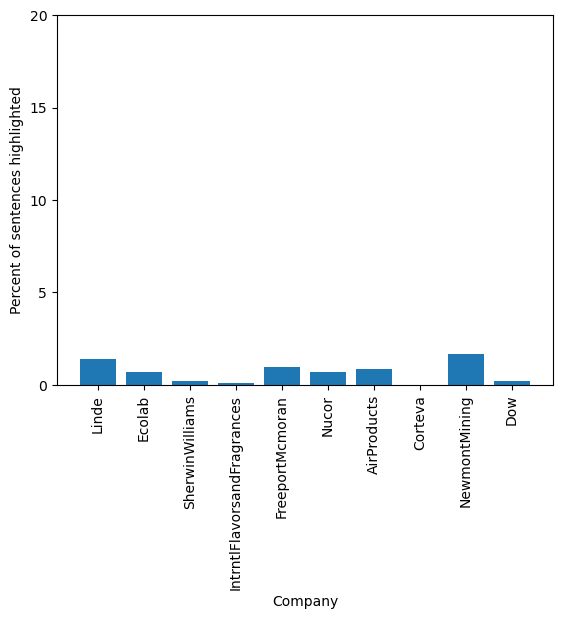

In [88]:
import matplotlib.pyplot as plt
import numpy as np
import glob
y = []

i = 0

for file in os.listdir(dir):
    y.append(100 * (rel_sent_list[i])/sentences_list[i])
    i = i+1

plt.bar(x_label, y, width = 0.8)
plt.xticks(rotation='vertical')
plt.xlabel("Company")
plt.ylabel("Percent of sentences highlighted")
plt.yticks(np.arange(0, 25, 5))
plt.show()

In [89]:
import pandas as pd

series = pd.Series(y)
series.describe()

count    9.000000
mean     0.764565
std      0.540794
min      0.107411
25%      0.234506
50%      0.717875
75%      0.963855
max      1.671733
dtype: float64

### Exporting and Saving Files 

In [90]:
#storing variable so they can be called between notebooks (for ML and aggregate work later on)

Materials_reltext = rel_text_df
Materials_alltext = all_text_df
Materials_stat = final_text_stat


%store Materials_reltext
%store Materials_alltext
%store Materials_stat

Stored 'Materials_reltext' (DataFrame)
Stored 'Materials_alltext' (DataFrame)
Stored 'Materials_stat' (DataFrame)
